# quant-econ Solutions: Modeling Career Choice

Solutions for http://quant-econ.net/jl/career.html

In [1]:
using PyPlot
using QuantEcon
include("career.jl")

get_greedy (generic function with 1 method)

/home/chase/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


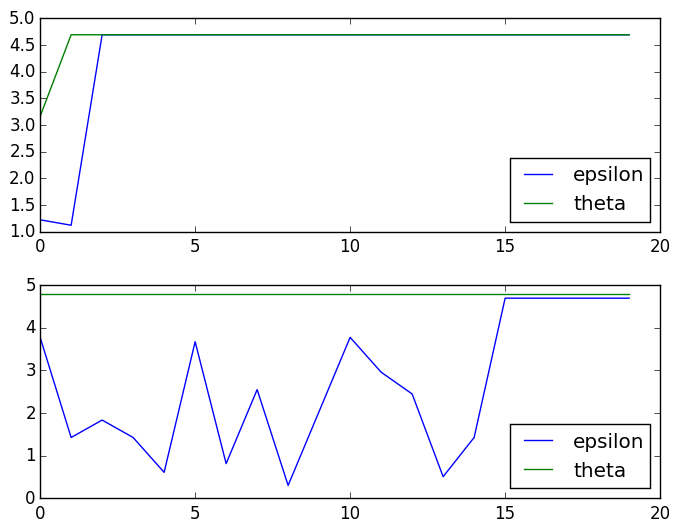

In [2]:
srand(41)  # reproducible results
wp = CareerWorkerProblem()

function solve_wp(wp::CareerWorkerProblem)
    v_init = fill(100.0, wp.N, wp.N)
    func(x) = bellman_operator(wp, x)
    v = compute_fixed_point(func, v_init, max_iter=500, verbose=false)
    optimal_policy = get_greedy(wp, v)
    return v, optimal_policy
end

v, optimal_policy = solve_wp(wp)

F = DiscreteRV(wp.F_probs)
G = DiscreteRV(wp.G_probs)

function gen_path(T=20)
    i = j = 1
    theta_ind = Int[]
    epsilon_ind = Int[]
    
    for t=1:T
        # do nothing if stay put
        if optimal_policy[i, j] == 2  # new job
            j = QuantEcon.draw(G)[1]
        elseif optimal_policy[i, j] == 3  # new life
            i, j = QuantEcon.draw(F)[1], QuantEcon.draw(G)[1]
        end
        push!(theta_ind, i)
        push!(epsilon_ind, j)
    end
    return wp.theta[theta_ind], wp.epsilon[epsilon_ind]
end

fig, axes = subplots(2, 1)
for ax in axes
    theta_path, epsilon_path = gen_path()
    ax[:plot](epsilon_path, label="epsilon")
    ax[:plot](theta_path, label="theta")
    ax[:legend](loc="lower right")
end
fig[:show]()  

## Exercise 2

The median for the original parameterization can be computed as follows

In [3]:
function gen_first_passage_time(optimal_policy::Matrix)
    t = 0
    i = j = 1
    while true
        if optimal_policy[i, j] == 1    # Stay put
            return t
        elseif optimal_policy[i, j] == 2  # New job
            j = QuantEcon.draw(G)[1]
        else                            # New life
            i, j = QuantEcon.draw(F)[1], QuantEcon.draw(G)[1]
        end
        t += 1
    end
end


M = 25000
samples = Array(Float64, M)
for i=1:M
    samples[i] = gen_first_passage_time(optimal_policy)
end
print(median(samples))

7.0

To compute the median with $\beta=0.99$ instead of the default value $\beta=0.95$,
replace `wp = CareerWorkerProblem()` with `wp = CareerWorkerProblem(beta=0.99)`

The medians are subject to randomness, but should be about 7 and 11
respectively.  Not surprisingly, more patient workers will wait longer to settle down to their final job

## Exercise 3

Here’s the code to reproduce the original figure

/home/chase/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


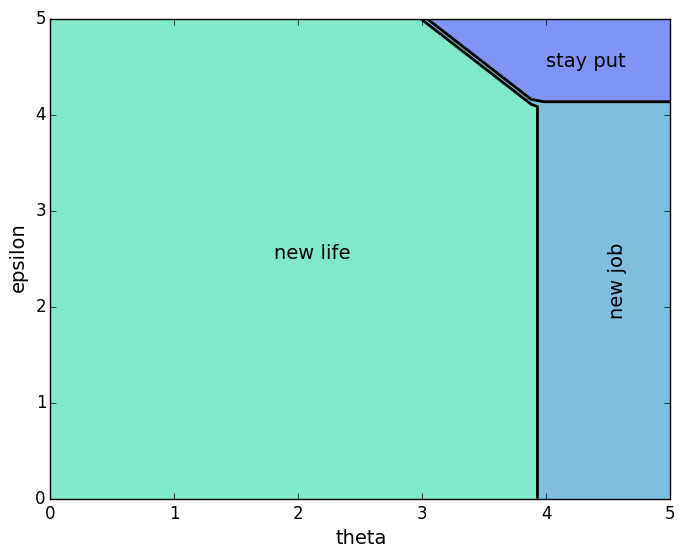

In [4]:
function region_plot(wp::CareerWorkerProblem)
    v, optimal_policy = solve_wp(wp)
    region_plot(optimal_policy)
end

function region_plot(optimal_policy::Matrix)
    fig, ax = subplots()
    tg, eg = meshgrid(collect(wp.theta), collect(wp.epsilon))
    lvls = [0.5, 1.5, 2.5, 3.5]

    ax[:contourf](tg, eg, optimal_policy', levels=lvls, cmap=ColorMap("winter"), 
                  alpha=0.5)
    ax[:contour](tg, eg, optimal_policy', colors="k", levels=lvls, linewidths=2)
    ax[:set_xlabel]("theta", fontsize=14)
    ax[:set_ylabel]("epsilon", fontsize=14)
    ax[:text](1.8, 2.5, "new life", fontsize=14)
    ax[:text](4.5, 2.5, "new job", fontsize=14, rotation="vertical")
    ax[:text](4.0, 4.5, "stay put", fontsize=14)
end

PyPlot.close("all")
region_plot(optimal_policy);

Now we want to set `G_a = G_b = 100` and generate a new figure with these parameters. 

To do this replace:

    wp = CareerWorkerProblem()

with:

    wp = CareerWorkerProblem(G_a=100, G_b=100)

In the new figure, you will see that the region for which the worker will stay put has grown because the distribution for $\epsilon$ has become more concentrated around the mean, making high-paying jobs less realistic


/home/chase/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


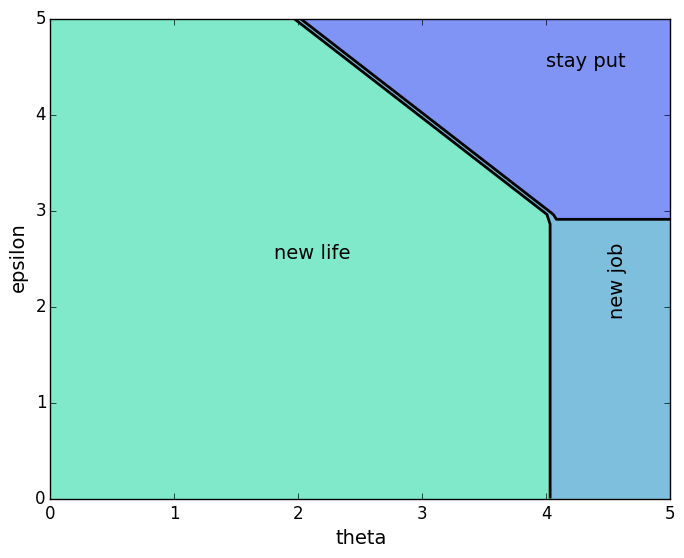

In [5]:
PyPlot.close("all")
region_plot(CareerWorkerProblem(G_a=100, G_b=100));